# Ensemble Learning and Random Forests

- Aggregating predictions of a group of predictors.
    - Often get better results than an individual predictor.
    - Group of predictors is an ensemble.
    - This technique is Ensemble learning and the ensemble learning algo is a.k.a Ensemble method.
    - Ensemble of Decision trees is called a Random Forest(RF)
    - Will explore bagging, boosting and stacking and RFs 

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import xgboost

### Voting Classifiers
- Assume ensemble contains multiple classifiers. Ex: Logistic regression, KNN, SVM, RF etc.

In [3]:
# Using the moons dataset
# TO-DO: Create script for train-test split.
X,y = make_moons(n_samples=1000, noise=0.4, random_state=42)
def create_train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = create_train_test(X,y)

#### Digression
##### Creating a single pipeline for training multiple classifiers:

In [13]:
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator = LogisticRegression()):self.estimator = estimator
    """
    A Custom BaseEstimator that can switch between classifiers.
    :param estimator: sklearn object - The classifier
    """
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [52]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ClfSwitcher()),
])
parameters = [
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__criterion': ['gini', 'entropy'],
        'clf__estimator__max_depth': [2,5,10]
    },
    {
        'clf__estimator': [SVC(probability=True)],
        'clf__estimator__kernel':['linear','rbf'],
        'clf__estimator__C':[2,4,6,8],
        'clf__estimator__tol': [1e-1,1e-2,1e-3]
    },
    {
        'clf__estimator': [LogisticRegression()],
        'clf__estimator__C': [2,4,6,8]
    }
]

In [53]:
clf_list = list() #Running a single grid search on all params gives the best classifier out of SVC, LR and RF. 
#In a for loop it gives the best classifier of every type.
for i in parameters:
    clf = GridSearchCV(pipeline, i, cv=5, n_jobs=-1, verbose=2)
    clf.fit(X_train, y_train)
    clf_list.append(clf)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    3.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [54]:
clf_list[1].best_estimator_ #List of best classifiers as found by GridSearchCV

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 ClfSwitcher(estimator=SVC(C=4, break_ties=False,
                                           cache_size=200, class_weight=None,
                                           coef0=0.0,
                                           decision_function_shape='ovr',
                                           degree=3, gamma='scale',
                                           kernel='rbf', max_iter=-1,
                                           probability=True, random_state=None,
                                           shrinking=True, tol=0.1,
                                           verbose=False)))],
         verbose=False)

#### Digression end

#### Hard Voting classifier
- Every classifier provides a predicted class which is a vote for that class.
- We total all the votes from the classifiers and provide the output of this ensemble as the class which received a majority share of the votes.

In [55]:
rnd_clf = clf_list[0].best_params_['clf__estimator']
svm_clf = clf_list[1].best_params_['clf__estimator']
log_clf = clf_list[2].best_params_['clf__estimator']
voting_clf = VotingClassifier(estimators=[('rf', rnd_clf), ('svc', svm_clf), ('lr', log_clf)],
                             voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=2,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
           

In [61]:
# Classifier Accuracy:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    y_pred = clf.predict(X_test)
    print('Accuracy score: '+ str(accuracy_score(y_test,y_pred)))

Accuracy score: 0.82
Accuracy score: 0.855
Accuracy score: 0.86
Accuracy score: 0.855


#### Soft Voting classifier
- Achieves higher performance than hard voting because it gives more weight to highly confident values i.e it averages the probability of the output provided by all the classifiers and decides. [In-depth explanation](https://stats.stackexchange.com/questions/349540/hard-voting-soft-voting-in-ensemble-based-methods)

In [59]:
rnd_clf_s = clf_list[0].best_params_['clf__estimator']
svm_clf_s = clf_list[1].best_params_['clf__estimator']
log_clf_s = clf_list[2].best_params_['clf__estimator']
voting_clf_s = VotingClassifier(estimators=[('rf', rnd_clf_s), ('svc', svm_clf_s), ('lr', log_clf_s)],
                             voting='soft')
voting_clf_s.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=2,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
           

In [60]:
for clf in (log_clf_s, rnd_clf_s, svm_clf_s, voting_clf_s):
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.82
RandomForestClassifier 0.855
SVC 0.86
VotingClassifier 0.86


- Ensemble methods work best when the predictors are trained on different algos since it creates diverse classifiers.
- Increases the chance that very diff types of errors will be made which improves the overall accuracy.
- That's why an ensemble could be a strong learner despite containing a lot of classifiers which are weak learners.

### Bagging and Pasting

- Using same training algo on diff random subsets of the training set.
- Bagging: Sampling of training instances is performed with replacement. (Bootstrap aggregating)
- Pasting: Sampling of training instances is performed without replacement.
- B & P allow training instances to be sampled multiple times for diff predictor but only B allows training instances to be sampled multiple times for the same predictor.
- After the predictors are trained, ensemble makes a prediction for a new instance based on the aggregation of the predictions. (uses mode)
- Generally individual predictor has a higher bias - underfit.
    - aggregation reduces bias and variance.
    - ensemble usually has similar bias and lower variance than individual predictor.
- Scale very well.

- NOTE: BaggingClassifier automatically performs soft voting if base estimator has a predict_proba()

In [63]:
#Bagging
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train,y_train)
y_pred_bag = bag_clf.predict(X_test)
print('Bagging accuracy: ', str(accuracy_score(y_test, y_pred_bag)))

Bagging accuracy:  0.85


In [64]:
#Pasting
pas_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=False, n_jobs=-1)
pas_clf.fit(X_train,y_train)
y_pred_pas = pas_clf.predict(X_test)
print('Pasting accuracy: ', str(accuracy_score(y_test, y_pred_pas)))

Pasting accuracy:  0.85


### Out of Bag evaluation
- There are instances which may not be sampled at all for a bagging predictor in an ensemble. 
- These unsampled instances can be used to estimate the prediction accuracy of the generated predictor.
- This can help evaluate the ensemble itself by averaging out the oob evaluations of each predictor.
- OOB score gives an idea of how the ensemble would perform on an unseen dataset. Usually similar values.

In [66]:
bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf_oob.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [67]:
bag_clf_oob.oob_score_

0.855

In [68]:
y_pred_oob = bag_clf_oob.predict(X_test)
print('Out of bag ensemble\'s accuracy: ', str(accuracy_score(y_test, y_pred_oob)))

Out of bag ensemble's accuracy:  0.855


### Random Patches and Random Subspaces
- Bagging classifier supports sampling of features as well i.e predictor is trained on a subset of the features.
- Works well in high dimensional datasets.
- Random Patches: Sampling both the training instances and the features.
- Random Subsample: Sampling only features and training on entire set of instances.
- max_features and bootstrap_features used.

### Random Forests
- RF is an ensemble of decision trees, trained via bagging or pasting.
- RandomForestClassifier is optimized for DTrees v/s using BaggingClassifier with DTrees. Similarly with RandomFOrestRegressor.

In [69]:
rnd_classifier = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_leaf_nodes=16)
rnd_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [70]:
y_pred_rf_clf = rnd_classifier.predict(X_test)
print('Accuracy of RF: '+str(accuracy_score(y_test,y_pred_rf_clf)))

Accuracy of RF: 0.85


In [71]:
#Previous RF is equivalent to this BaggingClassifier

bag_clf_rf = BaggingClassifier(DecisionTreeClassifier(splitter='random', max_leaf_nodes=16), n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
bag_clf_rf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=16,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

In [72]:
y_pred_bgrf = bag_clf_rf.predict(X_test)
print('Accuracy of RF: '+str(accuracy_score(y_test,y_pred_bgrf)))

Accuracy of RF: 0.86


### Extra-Trees
- When growing a tree in an RF, at each node only a random subset of the features is considered for splitting.
- Make trees random by using random thresholds for each feature rather than searching for the best possible thresholds.
- Such a forest of extremely random trees is called the Extremely Randomized Trees ensemble. Trades more bias for variance.
- Faster to train than an RF because RF training involves finding the best threshold for each feature at every node.
- Usually ET and RF performances are similar and comparison is done via performance on cross validation sets. 

In [79]:
et_clf = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_leaf_nodes=16)
et_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=16, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [80]:
y_pred_et = et_clf.predict(X_test)
print('Accuracy of Extra Trees: '+str(accuracy_score(y_test,y_pred_et)))

Accuracy of Extra Trees: 0.86


### Feature Importance
- Feature's importance can be measured by looking at how much a tree node reduces the impurity on average(weighted based on training samples per node) by using a particular feature.

In [82]:
iris = load_iris()
rnd_iris_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_iris_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_iris_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09099091590467746
sepal width (cm) 0.024303402700536166
petal length (cm) 0.4386757981280797
petal width (cm) 0.4460298832667066


### Boosting
- a.k.a Hypothesis Boosting
- Combines many weak learners into a strong learner.
- Train predictors sequentially, each trying to correct its predecessor.

#### AdaBoost
- Adaptive Boosting
- New predictor gives more importance to the misclassified instances of its predecessor.
- Sequential form of training which makes the training slow since it cannot be parallelized.
- Algo:
    - First the base predictor is trained and it is used to make predictions on the training set.
    - The algo then increases the relative weight of the instances which have been misclassified.
    - Then a 2nd predictor is trained using the updated weights and is made to predict on the training set and this process goes on, till the limit on the number of predictors is reached or when a perfect predictor is found.
    - Ensemble makes predictions similar to the way it's done in Bagging and pasting. Only difference is that: Predictors have different weights depending on the overall accuracy on the weighted training set.
    - SAMME.R - Multiclass version of AdaBoost which relies on class probabilities (predictor must have predict_proba()) - Typically performs better.

In [84]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [85]:
y_pred_ada = ada_clf.predict(X_test)
print('Accuracy of AdaBoost: '+str(accuracy_score(y_test,y_pred_ada)))

Accuracy of AdaBoost: 0.825


#### Gradient Boosting
- GB works by sequentially adding predictors to its ensemble, each one correcting its predecessor.
- Instead of tweaking instance weight values (AdaBoost), it trains the next predictor on the residual error values of the previous predictor.
- GB with decision trees is called Gradient tree boosting or Gradient Boosted Regression Trees (GBRT)

In [87]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Text(0, 0.5, 'y')

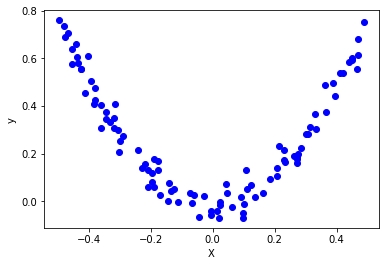

In [108]:
plt.plot(X,y, 'bo')
plt.xlabel('X')
plt.ylabel('y')

In [95]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [96]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [97]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [99]:
X_new = np.array([[0.9]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

- Learning rate hyperparameter scales the contribution of each tree.
    - If set to a low value like 0.1, we will need more trees in the ensemble to fit the training set, but the predictions will generalize better(in most cases)
    - This regularization technique is a.k.a shrinkage.

In [117]:
# Equivalent to the 3 predictors we created above
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [118]:
y_pred = gbrt.predict(X)

In [120]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [122]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

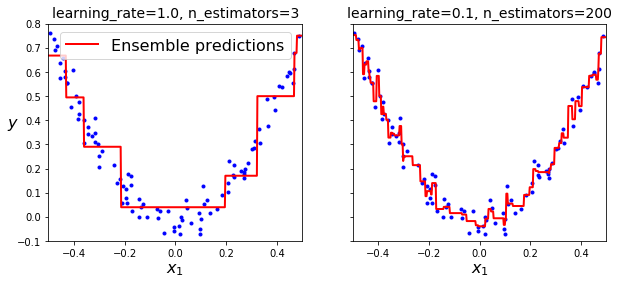

In [124]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

- Implement early stopping to find the optimal number of predictors

In [126]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [127]:
min_error = np.min(errors)
min_error

0.002712853325235463

In [128]:
print(gbrt_best.n_estimators)

56


#### Stochastic Gradient Boosting
- GradientBoostingRegressor supports a 'subsample' hyperparameter
    - If subsample = 0.25 then each tree is trained on 25% of the training instances selected randomly.
    - Trades higher bias for lower variance.
- Also speeds up training considerably.

#### XGBoost

In [133]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [134]:
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)

Validation MSE: 0.00400040950714611


In [136]:
# XGB with early stopping
xgb_reg_es = xgboost.XGBRegressor(random_state=42)
xgb_reg_es.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred_es = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129



In [137]:
val_error_es = mean_squared_error(y_val, y_pred_es) 
print("Validation MSE:", val_error_es)

Validation MSE: 0.00400040950714611


### Stacking
- Stacked Generalization
- Instead of using functions to aggregate the predictions of all the predictors in the ensemble, we can train a model to perform this aggregation.
- Each predictor predicts a value and passes it to the final predictor(blender of meta-learner).
- The blender takes these predictions as inputs and makes the final predictions.